### xgboost参数

- 选择较高的学习速率(learning rate)。一般情况下，学习速率的值为0.1。但是，对于不同的问题，理想的学习速率有时候会在0.05到0.3之间波动。选择对应于此学习速率的理想决策树数量。XGBoost有一个很有用的函数“cv”，这个函数可以在每一次迭代中使用交叉验证，并返回理想的决策树数量。 


- 对于给定的学习速率和决策树数量，进行决策树特定参数调优(max_depth, min_child_weight, gamma, subsample, colsample_bytree)。在确定一棵树的过程中，我们可以选择不同的参数，待会儿我会举例说明。  


- xgboost的正则化参数的调优。(lambda, alpha)。这些参数可以降低模型的复杂度，从而提高模型的表现。  


- 降低学习速率，确定理想参数。

#### 1.读取libsvm格式数据并指定参数建模

#### xgboost的使用方法
* ①使用xgboost自带的数据集格式 + xgboost自带的建模方式
    * 把数据读取成xgb.DMatrix格式(libsvm/dataframe.values给定X和Y)
    * 准备好一个watch_list(观测和评估的数据集)
    * xgb.train(dtrain)
    * xgb.predict(dtest)
* ②使用pandas的DataFrame格式 + xgboost的sklearn接口
    * estimator = xgb.XGBClassifier()/xgb.XGBRegressor()
    * estimator.fit(df_train.values, df_target.values)

In [3]:
#!/usr/bin/python
import numpy as np
#import scipy.sparse
import pickle
import xgboost as xgb

# 基本例子，从libsvm文件中读取数据，做二分类
# 数据是libsvm的格式
#1 3:1 10:1 11:1 21:1 30:1 34:1 36:1 40:1 41:1 53:1 58:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 105:1 117:1 124:1
#0 3:1 10:1 20:1 21:1 23:1 34:1 36:1 39:1 41:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 106:1 116:1 120:1
#0 1:1 10:1 19:1 21:1 24:1 34:1 36:1 39:1 42:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 106:1 116:1 122:1
dtrain = xgb.DMatrix('./data/agaricus.txt.train')
dtest = xgb.DMatrix('./data/agaricus.txt.test')

#超参数设定
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

# 设定watchlist用于查看模型状态
watchlist  = [(dtest,'eval'), (dtrain,'train')]
num_round = 2
bst = xgb.train(param, dtrain, num_round, watchlist)

# 使用模型预测
preds = bst.predict(dtest)

# 判断准确率
labels = dtest.get_label()
print ('错误类为%f' % \
       (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

# 模型存储
bst.save_model('./model/0001.model')

[15:49:14] 6513x127 matrix with 143286 entries loaded from ./data/agaricus.txt.train
[15:49:14] 1611x127 matrix with 35442 entries loaded from ./data/agaricus.txt.test
[0]	eval-error:0.042831	train-error:0.046522
[1]	eval-error:0.021726	train-error:0.022263
错误类为0.021726


#### 2.配合pandas DataFrame格式数据建模

In [4]:
# 皮马印第安人糖尿病数据集 包含很多字段：怀孕次数 口服葡萄糖耐量试验中血浆葡萄糖浓度 舒张压（mm Hg） 三头肌组织褶厚度（mm） 
# 2小时血清胰岛素（μU/ ml） 体重指数（kg/（身高(m)^2） 糖尿病系统功能 年龄（岁）
import pandas as pd
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 基本例子，从csv文件中读取数据，做二分类

# 用pandas读入数据
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 转换成Dmatrix格式
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)

#参数设定
param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }

# 设定watchlist用于查看模型状态
watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
num_round = 10
bst = xgb.train(param, xgtrain, num_round, watchlist)

# 使用模型预测
preds = bst.predict(xgtest)

# 判断准确率
labels = xgtest.get_label()
print ('错误类为%f' % \
       (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

# 模型存储
bst.save_model('./model/0002.model')

[0]	eval-error:0.322917	train-error:0.21875
[1]	eval-error:0.244792	train-error:0.168403
[2]	eval-error:0.255208	train-error:0.182292
[3]	eval-error:0.270833	train-error:0.170139
[4]	eval-error:0.244792	train-error:0.144097
[5]	eval-error:0.25	train-error:0.145833
[6]	eval-error:0.229167	train-error:0.144097
[7]	eval-error:0.25	train-error:0.145833
[8]	eval-error:0.239583	train-error:0.147569
[9]	eval-error:0.234375	train-error:0.140625
错误类为0.234375


#### 3.使用xgboost的sklearn包

In [6]:
#!/usr/bin/python
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


# 基本例子，从csv文件中读取数据，做二分类

# 用pandas读入数据
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 取出特征X和目标y的部分
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
train_X = train[feature_columns].values
train_y = train[target_column].values
test_X = test[feature_columns].values
test_y = test[target_column].values

# 初始化模型
xgb_classifier = xgb.XGBClassifier(n_estimators=20,\
                                   max_depth=4, \
                                   learning_rate=0.1, \
                                   subsample=0.7, \
                                   colsample_bytree=0.7)

# 拟合模型
xgb_classifier.fit(train_X, train_y)

# 使用模型预测
preds = xgb_classifier.predict(test_X)

# 判断准确率
print ('错误类为%f' %((preds!=test_y).sum()/float(test_y.shape[0])))

# 模型存储
joblib.dump(xgb_classifier, './model/0003.model')

错误类为0.276042


['./model/0003.model']

#### 4.交叉验证

In [7]:
xgb.cv(param, dtrain, num_round, nfold=5,metrics={'error'}, seed = 0)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.006832,0.001012,0.006756,0.001407
1,0.002994,0.002806,0.002303,0.002524
2,0.001382,0.000352,0.001382,0.001228
3,0.001190,0.000658,0.001382,0.001228
4,0.001382,0.000282,0.001075,0.000921
5,0.000921,0.000506,0.001228,0.001041
6,0.000921,0.000506,0.001228,0.001041
7,0.000921,0.000506,0.001228,0.001041
8,0.000921,0.000506,0.001228,0.001041
9,0.000921,0.000506,0.001228,0.001041


#### 5.添加预处理的交叉验证

In [8]:
# 计算正负样本比，调整样本权重
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label==1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

# 先做预处理，计算样本权重，再做交叉验证
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'auc'}, seed = 0, fpreproc = fpreproc)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.999772,0.000126,0.999731,0.000191
1,0.999942,0.000044,0.999909,0.000085
2,0.999964,0.000035,0.999926,0.000084
3,0.999979,0.000036,0.999950,0.000089
4,0.999976,0.000043,0.999946,0.000098
5,0.999994,0.000010,0.999988,0.000020
6,0.999993,0.000012,0.999988,0.000020
7,0.999993,0.000012,0.999988,0.000020
8,0.999993,0.000012,0.999988,0.000020
9,0.999993,0.000012,0.999988,0.000020


#### 6.自定义损失函数与评估准则

In [9]:
print ('running cross validation, with cutomsized loss function')
# 自定义损失函数，需要提供损失函数的一阶导和二阶导
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0-preds)
    return grad, hess

# 自定义评估准则，评估预估值和标准答案之间的差距
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

watchlist  = [(dtest,'eval'), (dtrain,'train')]
param = {'max_depth':3, 'eta':0.1, 'silent':1}
num_round = 5
# 自定义损失函数训练
bst = xgb.train(param, dtrain, num_round, watchlist, logregobj, evalerror)
# 交叉验证
xgb.cv(param, dtrain, num_round, nfold = 5, seed = 0,
       obj = logregobj, feval=evalerror)

running cross validation, with cutomsized loss function
[0]	eval-rmse:0.306902	train-rmse:0.306163	eval-error:0.518312	train-error:0.517887
[1]	eval-rmse:0.17919	train-rmse:0.177276	eval-error:0.518312	train-error:0.517887
[2]	eval-rmse:0.172566	train-rmse:0.171727	eval-error:0.016139	train-error:0.014433
[3]	eval-rmse:0.269611	train-rmse:0.271113	eval-error:0.016139	train-error:0.014433
[4]	eval-rmse:0.396904	train-rmse:0.398245	eval-error:0.016139	train-error:0.014433


,train-error-mean,train-error-std,train-rmse-mean,train-rmse-std,test-error-mean,test-error-std,test-rmse-mean,test-rmse-std
0,0.517887,0.001085,0.308880,0.005170,0.517886,0.004343,0.309038,0.005207
1,0.517887,0.001085,0.176504,0.002046,0.517886,0.004343,0.177802,0.003767
2,0.014433,0.000223,0.172680,0.003719,0.014433,0.000892,0.174890,0.009391
3,0.014433,0.000223,0.275761,0.001776,0.014433,0.000892,0.276689,0.005918
4,0.014433,0.000223,0.399889,0.003369,0.014433,0.000892,0.400118,0.006243


#### 7.只用前n颗树预测

In [10]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 基本例子，从csv文件中读取数据，做二分类

# 用pandas读入数据
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 转换成Dmatrix格式
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)

#参数设定
param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }

# 设定watchlist用于查看模型状态
watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
num_round = 10
bst = xgb.train(param, xgtrain, num_round, watchlist)

# 只用第1颗树预测
ypred1 = bst.predict(xgtest, ntree_limit=1)
# 用前9颗树预测
ypred2 = bst.predict(xgtest, ntree_limit=9)
label = xgtest.get_label()
print ('用前1颗树预测的错误率为 %f' % (np.sum((ypred1>0.5)!=label) /float(len(label))))
print ('用前9颗树预测的错误率为 %f' % (np.sum((ypred2>0.5)!=label) /float(len(label))))

[0]	eval-error:0.28125	train-error:0.203125
[1]	eval-error:0.182292	train-error:0.1875
[2]	eval-error:0.21875	train-error:0.184028
[3]	eval-error:0.213542	train-error:0.175347
[4]	eval-error:0.223958	train-error:0.164931
[5]	eval-error:0.223958	train-error:0.164931
[6]	eval-error:0.208333	train-error:0.164931
[7]	eval-error:0.192708	train-error:0.15625
[8]	eval-error:0.21875	train-error:0.15625
[9]	eval-error:0.208333	train-error:0.147569
用前1颗树预测的错误率为 0.281250
用前9颗树预测的错误率为 0.218750


### sklearn与Xgboost配合使用
#### 1.Xgboost建模，sklearn评估

In [11]:
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston

rng = np.random.RandomState(31337)

#二分类：混淆矩阵
print("数字0和1的二分类问题")
digits = load_digits(2)
y = digits['target']
X = digits['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#多分类：混淆矩阵
print("\nIris: 多分类")
iris = load_iris()
y = iris['target']
X = iris['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#回归问题：MSE
print("\n波士顿房价回归预测问题")
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("MSE:",mean_squared_error(actuals, predictions))

数字0和1的二分类问题
在2折数据上的交叉验证
混淆矩阵:
[[87  0]
 [ 1 92]]
混淆矩阵:
[[91  0]
 [ 3 86]]

Iris: 多分类
在2折数据上的交叉验证
混淆矩阵:
[[19  0  0]
 [ 0 31  3]
 [ 0  1 21]]
混淆矩阵:
[[31  0  0]
 [ 0 16  0]
 [ 0  3 25]]

波士顿房价回归预测问题
在2折数据上的交叉验证
[15:53:36] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 9.860776812557337
[15:53:36] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 15.942418468446029


#### 2.网格搜索查找最优超参数

In [12]:
# 第2种训练方法的 调参方法：使用sklearn接口的regressor + GridSearchCV
print("参数最优化：")
y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRegressor()
param_dict = {'max_depth': [2,4,6],
              'n_estimators': [50,100,200]}

clf = GridSearchCV(xgb_model, param_dict, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

参数最优化：
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[15:53:37] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:37] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:37] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:37] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:37] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:37] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:37] WARNING: d:\build\xgbo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:53:38] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:38] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:38] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:38] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:38] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:38] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:38] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linea

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.7s finished


#### 3.early-stopping 早停

In [13]:
# 第1/2种训练方法的 调参方法：early stopping
# 在训练集上学习模型，一颗一颗树添加，在验证集上看效果，当验证集效果不再提升，停止树的添加与生长
X = digits['data']
y = digits['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.999497
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999497
[2]	validation_0-auc:0.999497
[3]	validation_0-auc:0.999749
[4]	validation_0-auc:0.999749
[5]	validation_0-auc:0.999749
[6]	validation_0-auc:0.999749
[7]	validation_0-auc:0.999749
[8]	validation_0-auc:0.999749
[9]	validation_0-auc:0.999749
[10]	validation_0-auc:1
[11]	validation_0-auc:1
[12]	validation_0-auc:1
[13]	validation_0-auc:1
[14]	validation_0-auc:1
[15]	validation_0-auc:1
[16]	validation_0-auc:1
[17]	validation_0-auc:1
[18]	validation_0-auc:1
[19]	validation_0-auc:1
[20]	validation_0-auc:1
Stopping. Best iteration:
[10]	validation_0-auc:1



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

#### 4.特征重要度

特征排序：
特征 petal_length 重要度为 0.595834
特征 petal_width 重要度为 0.358166
特征 sepal_width 重要度为 0.033481
特征 sepal_length 重要度为 0.012520


([<matplotlib.axis.XTick at 0x1ed5a5bc7b8>,
 <a list of 4 Text xticklabel objects>)

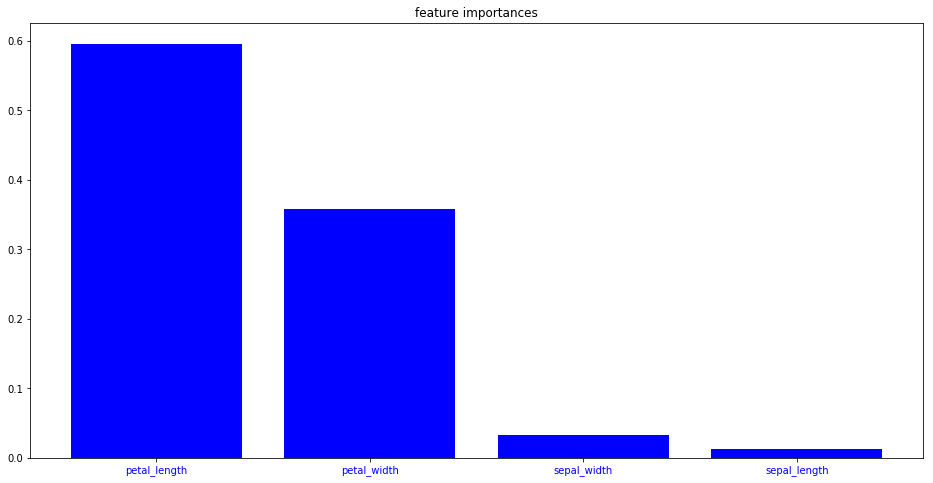

In [14]:
iris = load_iris()
y = iris['target']
X = iris['data']
xgb_model = xgb.XGBClassifier().fit(X,y)

print('特征排序：')
feature_names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

for index in indices:
    print("特征 %s 重要度为 %f" %(feature_names[index], feature_importances[index]))

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title("feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], color='b')

#### 5.并行训练加速

In [ ]:
import os

if __name__ == "__main__":
    try:
        from multiprocessing import set_start_method
    except ImportError:
        raise ImportError("Unable to import multiprocessing.set_start_method."
                          " This example only runs on Python 3.4")
    set_start_method("forkserver")

    import numpy as np
    from sklearn.model_selection import GridSearchCV
    from sklearn.datasets import load_boston
    import xgboost as xgb

    rng = np.random.RandomState(31337)

    print("Parallel Parameter optimization")
    boston = load_boston()

    os.environ["OMP_NUM_THREADS"] = "2"  # or to whatever you want
    y = boston['target']
    X = boston['data']
    xgb_model = xgb.XGBRegressor()
    clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                   'n_estimators': [50, 100, 200]}, verbose=1,
                       n_jobs=2)
    clf.fit(X, y)
    print(clf.best_score_)
    print(clf.best_params_)